In [1]:
import numpy as np
import pandas as pd
import joblib
import warnings
import collections
from itertools import zip_longest

# from sklearn.gaussian_process import GaussianProcessRegressor
# from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel, RBF, ConstantKernel

# from sklearn.linear_model import LinearRegression

from scipy.optimize import curve_fit
import GPy
import matplotlib.pyplot as plt
%matplotlib inline
warnings.filterwarnings('ignore')

In [9]:
def load_data(data_no=1): 
    data = joblib.load('./test_HA/test_HA_0%d.lz4'%data_no) 
    return data

def cl_mean(mean_list, seg_cl, up_thred = 30, down_thred= 0, confidence=0.5):
    mean_list_copy = mean_list.copy()
     # 标记超出阈值的样本为-1
    for i in range(len(mean_list)):
        idx_mean = mean_list[i]
        if (idx_mean>up_thred) or (idx_mean<down_thred):
            mean_list[i] = -1
    
    # 拟合粗趋势
    ser = pd.Series(mean_list)
    ser.index = seg_cl #index
    if sum(ser != -1)<=1:
        print('超出阈值的样本数量过多！')
    x_train = ser.index[ser != -1].values
    y_train = ser[ser != -1].values
    
    f1 = np.polyfit(x_train, y_train, 2)
    p1 = np.poly1d(f1)
    tmp = p1(seg_cl)
    mean_list = list(tmp)
    
    # 纠正
    for i in range(len(mean_list)):
        idx_mean = mean_list_copy[i]
        cmp_mean = mean_list[i]
        if np.abs(idx_mean - cmp_mean) >= confidence:
            pass
        else:
            mean_list[i] = idx_mean 
            
    return seg_cl, mean_list, p1

def CL_mean_auto(df, apply_col, seg_col, up_thred = 30, down_thred= 0, use_predict=True):
    '''
    描述：
        统计每一段时间的某一列均值，并拟合曲线
    '''
    data = df[apply_col]
    seg_cl = df[seg_col].unique()
    seg_cl.sort()
    
    
    # 初始化delta_list
    mean_list = []
    for cl in seg_cl:
        seg_mean = data[df[seg_col] == cl].mean()
        mean_list.append(seg_mean)
    if not use_predict:
        return mean_list
    
    seg_cl, mean_list, _ = cl_mean(mean_list, seg_cl, up_thred, down_thred= 0, confidence=1.5)   
    return seg_cl, mean_list


In [3]:
def cl_percent_delta(delta_list, seg_cl, up_thred=30, down_thred=0, confidence=0.5):
    delta_list_copy = delta_list.copy()
    
    # 标记超出阈值的样本为-1
    for i in range(len(delta_list)):
        idx_delta = delta_list[i]
        if (idx_delta>up_thred) or (idx_delta<down_thred):
            delta_list[i] = -1
    
    # 拟合粗趋势
    ser = pd.Series(delta_list)
    ser.index = seg_cl #index
    if sum(ser != -1)<=1:
        print('超出阈值的样本数量过多！')
    x_train = ser.index[ser != -1].values
    y_train = ser[ser != -1].values
    
    f1 = np.polyfit(x_train, y_train, 2)
    p1 = np.poly1d(f1)
    tmp = p1(seg_cl)
    delta_list = list(tmp)
    print(delta_list)
     # 纠正
    for i in range(len(delta_list)):
        idx_delta = delta_list_copy[i]
        cmp_delta = delta_list[i]
        if np.abs(idx_delta - cmp_delta) >= confidence:
            pass
        else:
            delta_list[i] = idx_delta 
    return seg_cl, delta_list

def CL_percent_delta_auto(df, apply_col, seg_col, up_box=90, down_box=10, up_thred=10, down_thred=0, use_predict = True):
    '''
    描述：
        统计每一段时间的某一列变化范围，并拟合曲线， 不需给出correct_idx
    '''
    data = df[apply_col]
    seg_cl = df[seg_col].unique()
    seg_cl.sort()
    
    # 初始化delta_list
    delta_list = []
    for cl in seg_cl:
        tmp = data[df[seg_col] == cl]
        up_bound = np.percentile(tmp, up_box)
        down_bound = np.percentile(tmp, down_box)
        cl_delta = up_bound - down_bound
        delta_list.append(cl_delta)
    if not use_predict:
        return seg_cl, delta_list
    cl, delta_list = cl_percent_delta(delta_list, seg_cl, up_thred, down_thred, confidence=2.5) 
    return seg_cl, delta_list
            


In [4]:
plt.figure(figsize=(16,8))
cl, delta_list = CL_percent_delta_auto(test_01, 'PCA_T2', 'CLI', up_box=95, down_box=5, up_thred=10, down_thred=0, use_predict=True)
# cl, delta_list = cl_percent_delta(delta_list, cl, up_thred=30, down_thred=0, confidence=0.1)
plt.plot(range(1,11), delta_list, label='train_01')

NameError: name 'test_01' is not defined

<Figure size 1152x576 with 0 Axes>

In [5]:
test_01 = joblib.load('./test_HA/test_HA_01.lz4')
test_02 = joblib.load('./test_HA/test_HA_02.lz4')
test_03 = joblib.load('./test_HA/test_HA_03.lz4')
test_04 = joblib.load('./test_HA/test_HA_04.lz4')
test_05 = joblib.load('./test_HA/test_HA_05.lz4')

In [6]:
train_01 = joblib.load('./train_HA/train_HA_01.lz4')
train_02 = joblib.load('./train_HA/train_HA_02.lz4')
train_03 = joblib.load('./train_HA/train_HA_03.lz4')

## 计算均值

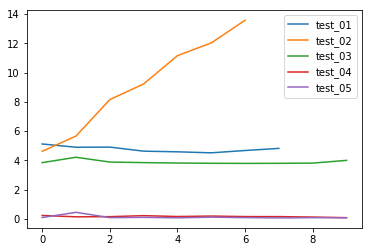

In [11]:
cl, mean_list = CL_mean_auto(test_01, 'PCA_T2', 'CLI', 30, 0, use_predict=True)
cl, mean_list, _ = cl_mean(mean_list, cl, confidence=0.3)
plt.plot( mean_list, label='test_01')

cl, mean_list = CL_mean_auto(test_02, 'PCA_T2', 'CLI', 30, 0, use_predict=True)
cl, mean_list, _ = cl_mean(mean_list, cl, confidence=0.3)
plt.plot( mean_list, label='test_02')

cl, mean_list = CL_mean_auto(test_03, 'PCA_T2', 'CLI', 30, 0, use_predict=True)
cl, mean_list, _ = cl_mean(mean_list, cl, confidence=0.3)
plt.plot( mean_list, label='test_03')

cl, mean_list = CL_mean_auto(test_04, 'PCA_T2', 'CLI', 30, 0, use_predict=True)
cl, mean_list, _ = cl_mean(mean_list, cl, confidence=0.3)
plt.plot( mean_list, label='test_04')

cl, mean_list = CL_mean_auto(test_05, 'PCA_T2', 'CLI', 30, 0, use_predict=True)
cl, mean_list, _ = cl_mean(mean_list, cl, confidence=0.3)
plt.plot( mean_list, label='test_05')
plt.legend()

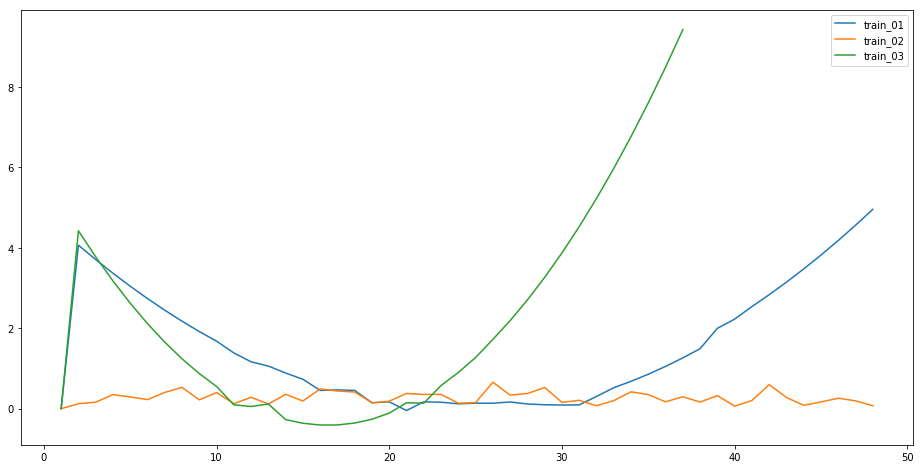

In [14]:
plt.figure(figsize=(16,8))
cl, mean_list = CL_mean_auto(train_01, 'PCA_T2', 'CLI', 30, 0, use_predict=True)
cl, mean_list, p = cl_mean(mean_list, cl, confidence=0.3)
mean_list[0] = 0
plt.plot(range(1,49), mean_list, label='train_01')

cl, mean_list = CL_mean_auto(train_02,  'PCA_T2', 'CLI', 30, 0, use_predict=True)
cl, mean_list, p = cl_mean(mean_list, cl, confidence=0.3)
mean_list[0] = 0
plt.plot(range(1,49), mean_list, label='train_02')

cl, mean_list = CL_mean_auto(train_03, 'PCA_T2', 'CLI', 30, 0, use_predict=True)
cl, mean_list, p = cl_mean(mean_list, cl, confidence=0.3)
mean_list[0] = 0
plt.plot(range(1,38), mean_list, label='train_03')
plt.legend()

## 变化幅度

[0.27584666010831194, 0.278595605309329, 0.2813643966292841, 0.2841530340681772, 0.28696151762600836, 0.28978984730277757, 0.29263802309848475, 0.29550604501313, 0.2983939130467132, 0.3013016271992345, 0.3042291874706938, 0.3071765938610911, 0.31014384637042647, 0.3131309449986998, 0.3161378897459112, 0.31916468061206066, 0.3222113175971481, 0.32527780070117357, 0.32836412992413705, 0.3314703052660386, 0.3345963267268781, 0.3377421943066557, 0.3409079080053713, 0.3440934678230249, 0.34729887375961654, 0.35052412581514625, 0.3537692239896139, 0.3570341682830196, 0.36031895869536334, 0.3636235952266451, 0.3669480778768649, 0.37029240664602275, 0.37365658153411857, 0.37704060254115246, 0.3804444696671243, 0.38386818291203423, 0.38731174227588216, 0.3907751477586682, 0.39425839936039214, 0.3977614970810541, 0.4012844409206542, 0.40482723087919226, 0.40838986695666835, 0.41197234915308245, 0.4155746774684346, 0.4191968519027247, 0.4228388724559529, 0.42650073912811914]
[1.0586037911738826, 

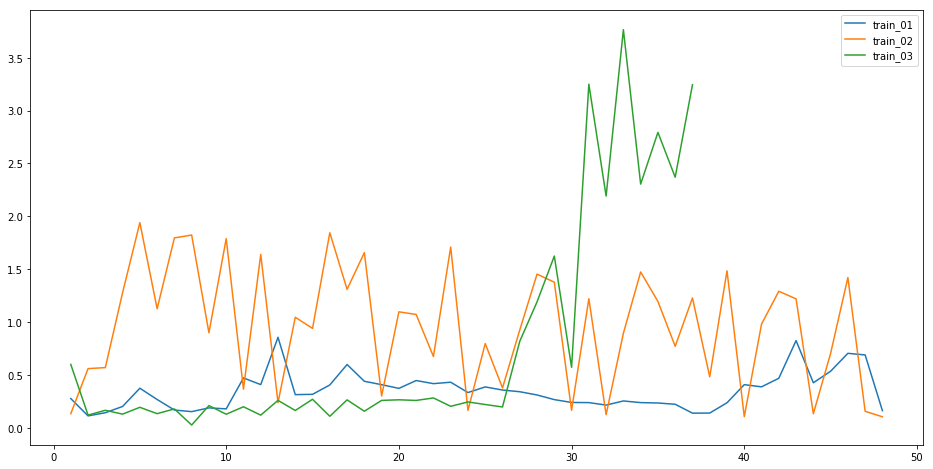

In [15]:
plt.figure(figsize=(16,8))
cl, delta_list = CL_percent_delta_auto(train_01, 'PCA_T2', 'CLI', up_box=95, down_box=5, up_thred=10, down_thred=0, use_predict=True)
# cl, delta_list = cl_percent_delta(delta_list, cl, up_thred=30, down_thred=0, confidence=0.1)
plt.plot(range(1,49), delta_list, label='train_01')

cl, delta_list = CL_percent_delta_auto(train_02, 'PCA_T2', 'CLI', up_box=95, down_box=5, up_thred=10, down_thred=0, use_predict=True)
# cl, delta_list = cl_percent_delta(delta_list, cl, up_thred=30, down_thred=0,  confidence=0.1)
plt.plot(range(1,49), delta_list, label='train_02')

cl, delta_list = CL_percent_delta_auto(train_03, 'PCA_T2', 'CLI', up_box=95, down_box=5, up_thred=10, down_thred=0, use_predict=True)
# cl, delta_list = cl_percent_delta(delta_list, cl, up_thred=30, down_thred=0,  confidence=0.1)
plt.plot(range(1,38), delta_list, label='train_03')
plt.legend()

[0.5463521156319032, 0.5711657056153707, 0.5944911682331712, 0.6163285034853043, 0.6366777113717704, 0.6555387918925693, 0.672911745047701, 0.6887965708371655, 0.703193269260963, 0.7161018403190932, 0.7275222840115563, 0.7374546003383522, 0.7458987892994808, 0.7528548508949424, 0.7583227851247368, 0.7623025919888641, 0.7647942714873242, 0.7657978236201171, 0.7653132483872428, 0.7633405457887013, 0.7598797158244927, 0.754930758494617, 0.7484936737990739, 0.7405684617378638, 0.7311551223109867, 0.7202536555184422, 0.7078640613602305, 0.6939863398363518, 0.6786204909468058, 0.6617665146915928, 0.6434244110707125, 0.6235941800841651, 0.6022758217319504, 0.5794693360140687, 0.5551747229305197, 0.5293919824813036, 0.5021211146664204, 0.47336211948587, 0.44311499693965223, 0.41137974702776753, 0.37815636975021566, 0.34344486510699646, 0.30724523309811025, 0.2695574737235568, 0.2303815869833361, 0.1897175728774484, 0.1475654314058935, 0.10392516256867129]
[0.5281783122730251, 0.750285859714891

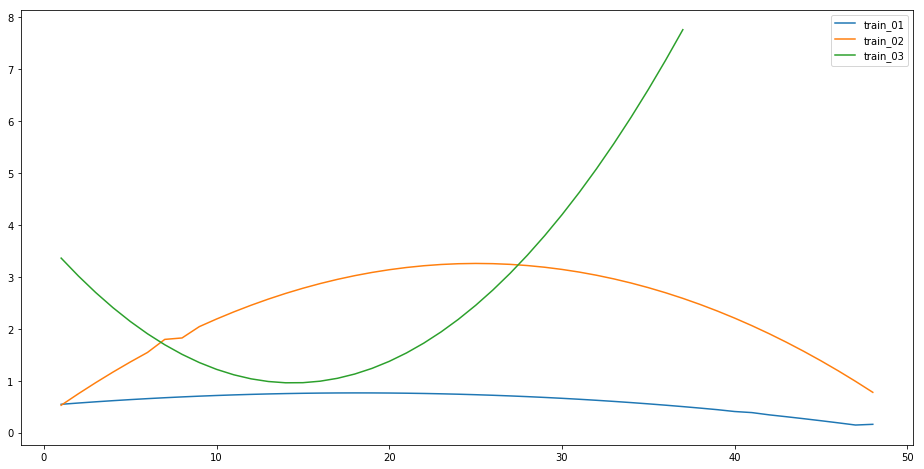

In [16]:
plt.figure(figsize=(16,8))
cl, delta_list = CL_percent_delta_auto(train_01, 'PCA_T2', 'CLI', up_box=95, down_box=5, up_thred=10, down_thred=0, use_predict=False)
cl, delta_list = cl_percent_delta(delta_list, cl, up_thred=30, down_thred=0, confidence=0.1)
plt.plot(range(1,49), delta_list, label='train_01')

cl, delta_list = CL_percent_delta_auto(train_02, 'PCA_T2', 'CLI', up_box=95, down_box=5, up_thred=10, down_thred=0, use_predict=False)
cl, delta_list = cl_percent_delta(delta_list, cl, up_thred=30, down_thred=0,  confidence=0.1)
plt.plot(range(1,49), delta_list, label='train_02')

cl, delta_list = CL_percent_delta_auto(train_03, 'PCA_T2', 'CLI', up_box=95, down_box=5, up_thred=10, down_thred=0, use_predict=False)
cl, delta_list = cl_percent_delta(delta_list, cl, up_thred=30, down_thred=0,  confidence=0.1)
plt.plot(range(1,38), delta_list, label='train_03')
plt.legend()

[-0.06930623245717449, 0.22551643054181358, 0.47394380298229155, 0.6759758848642603, 0.8316126761877172, 0.9408541769526657, 1.0037003871591033, 0.990206935896448]
[2.7651627865562443, 2.7297732874387677, 2.4323729942397616, 2.1703622001582294, 1.419719317031113, 0.9310872279855298, -0.2727982450696942]
[0.17899443008223603, 0.17464596719518485, 0.17066870440169737, 0.1670626417017736, 0.16382777909541357, 0.16096411658261728, 0.15847165416338466, 0.15635039183771576, 0.1546003296056106, 0.15322146746706916]
[0.4482366668332415, 0.4316081480562243, 0.4113320673185365, 0.38740842462017805, 0.35983721996114904, 0.3286184533414495, 0.29375212476107937, 0.25523823422003855, 0.21307678171832728, 0.16726776725594544]
[0.20508990661864424, 0.19454641641771686, 0.1860035987572748, 0.17946145363731802, 0.17491998105784656, 0.17237918101886052, 0.17183905352035977, 0.17329959856234434, 0.17676081614481443, 0.1822227062677696]


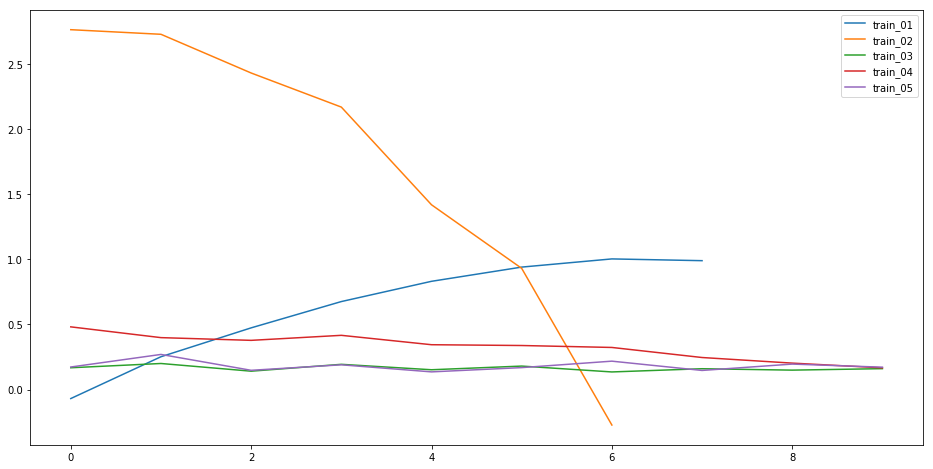

In [18]:
plt.figure(figsize=(16,8))
cl, delta_list = CL_percent_delta_auto(test_01, 'PCA_T2', 'CLI', up_box=95, down_box=5, up_thred=10, down_thred=0, use_predict=False)
cl, delta_list = cl_percent_delta(delta_list, cl, up_thred=30, down_thred=0, confidence=0.1)
plt.plot(delta_list, label='train_01')

cl, delta_list = CL_percent_delta_auto(test_02, 'PCA_T2', 'CLI', up_box=95, down_box=5, up_thred=10, down_thred=0, use_predict=False)
cl, delta_list = cl_percent_delta(delta_list, cl, up_thred=30, down_thred=0,  confidence=0.1)
plt.plot(delta_list, label='train_02')

cl, delta_list = CL_percent_delta_auto(test_03, 'PCA_T2', 'CLI', up_box=95, down_box=5, up_thred=10, down_thred=0, use_predict=False)
cl, delta_list = cl_percent_delta(delta_list, cl, up_thred=30, down_thred=0,  confidence=0.1)
plt.plot(delta_list, label='train_03')

cl, delta_list = CL_percent_delta_auto(test_04, 'PCA_T2', 'CLI', up_box=95, down_box=5, up_thred=10, down_thred=0, use_predict=False)
cl, delta_list = cl_percent_delta(delta_list, cl, up_thred=30, down_thred=0,  confidence=0.1)
plt.plot(delta_list, label='train_04')

cl, delta_list = CL_percent_delta_auto(test_05, 'PCA_T2', 'CLI', up_box=95, down_box=5, up_thred=10, down_thred=0, use_predict=False)
cl, delta_list = cl_percent_delta(delta_list, cl, up_thred=30, down_thred=0,  confidence=0.1)
plt.plot(delta_list, label='train_05')
plt.legend()